##### In the US, public companies need to regularly file various statements and reports to the SEC's (Securities and Exchange Commission) EDGAR database. EDGAR data is publicly available online; furthermore, web requests to EDGAR from around the world are logged and published.
##### We'll develop tools to extract information from the filings stored in EDGAR.

##### 在美国，上市公司需要定期向 SEC（证券交易委员会）的 EDGAR 数据库提交各种报表和报告。EDGAR 数据可在线公开获取；此外，来自世界各地的对 EDGAR 的网络请求被记录和发布。
##### 我们将开发工具以从存储在 EDGAR 中的文件中提取信息。

##### 查看 EDGAR 站点上的每日 zip 和 CSV 文档列表：

https://www.sec.gov/dera/data/edgar-log-file-data-set.html
https://www.sec.gov/files/EDGAR_variables_FINAL.pdf

In [1]:
import requests
import os
import pandas as pd
import zipfile
from collections import Counter
import csv
import pandas as pd
from zipfile import ZipFile, ZIP_DEFLATED
from io import TextIOWrapper
import re
from collections import defaultdict

In [3]:
with zipfile.ZipFile('server_log.zip') as zf:
    with zf.open("rows.csv") as f:
        df_1 = pd.read_csv(f)

##### How many filings have been accessed by the top ten IPs?
##### 排名前十的IP访问了多少申请？

In [4]:
dict(Counter(list(df_1['ip'])).most_common()[0:10])

{'54.152.17.ccg': 12562,
 '183.195.251.hah': 6524,
 '52.45.218.ihf': 5562,
 '68.180.231.abf': 5493,
 '204.212.175.bch': 4708,
 '103.238.106.gif': 4428,
 '208.77.215.jeh': 3903,
 '208.77.214.jeh': 3806,
 '217.174.255.dgd': 3551,
 '82.13.163.caf': 3527}

##### 错误访问请求的比率

In [18]:
df_sort_dict=dict(Counter(list(df_1['code'])).most_common())
keys_400=[x for x in list(df_sort_dict.keys()) if x>=400.0]

count_400=0
for x in keys_400:
    count_400+=df_sort_dict[x]
count_400/sum(df_sort_dict.values())

0.03466852724527611

##### 访问频率最高的文件

In [17]:
df_ad=df_1[['cik','accession','extention']]
new_cik=[str(int(x)) for x in list(df_ad['cik'])]
df_ad.loc[:,'cik']=new_cik
ad_list=df_ad.values.tolist()

join_4=['/'.join(x) for x in ad_list]

detail = Counter(join_4)
detail.most_common(1)[0][0]

/Users/zhuoyujiang/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


'1627631/0001627631-15-000004/.txt'

In [9]:
import edgar_utils

In [10]:
ip_dict=dict(Counter(list(df_1['ip'])))
ip_list=list(ip_dict.keys())
ip_times=list(ip_dict.values())
ip_region=[]
for x in ip_list:
    ip_region.append(edgar_utils.lookup_region(x))
dict_region={'region':ip_region,
             'ip':ip_list,
             'values':ip_times}

##### 哪个地区使用EDGAR最多

In [11]:
r_list=list(set(ip_region))
    
d = defaultdict(list)
for i, v in enumerate(ip_region):
    d[v].append(i)

full_data=pd.DataFrame.from_dict(dict_region, orient='index')
region_value={}
for x in r_list:
    y=sum(full_data.iloc[2,d[x]])
    region_value[x]=y
sorted(region_value.items(),key=lambda item:item[1])[-1][0]

'United States of America'

##### 每个地区IP中有多少比例的高流量用户？

In [12]:
high_volume={}
for x in r_list:
    full_list=list(full_data.iloc[2,d[x]])
    high_list=[]
    for y in full_list:
        if y>=1000:
            high_list.append(y)
    high_volume[x]=len(high_list)/len(full_list)
high_volume

{'Bangladesh': 0.0,
 'Viet Nam': 0.0,
 'Czechia': 0.0,
 'Cyprus': 0.0,
 'Hungary': 0.0,
 'China': 0.006864988558352402,
 'Egypt': 0.0,
 'Indonesia': 0.0,
 'Canada': 0.017857142857142856,
 'Armenia': 0.0,
 'Italy': 0.0,
 'Switzerland': 0.0,
 'Estonia': 0.0,
 'Germany': 0.0,
 'Jordan': 0.0,
 'Tanzania, United Republic of': 0.0,
 'Romania': 0.0,
 'Mexico': 0.0,
 'Japan': 0.0,
 'Portugal': 0.0,
 'Lebanon': 0.0,
 'Syrian Arab Republic': 0.0,
 'Sudan': 0.0,
 'Mongolia': 0.0,
 'Korea (Republic of)': 0.2,
 'Philippines': 0.0,
 'Algeria': 0.0,
 'Yemen': 0.0,
 'Russian Federation': 0.0,
 'Finland': 0.0,
 'Hong Kong': 0.0,
 'Slovakia': 0.0,
 'Liberia': 0.0,
 'Denmark': 0.0,
 'Netherlands': 0.0,
 'Ukraine': 0.0,
 'Iraq': 0.0,
 'South Africa': 0.0,
 'Bulgaria': 0.3333333333333333,
 'Thailand': 0.0,
 'Greece': 0.0,
 'Brazil': 0.0,
 'Slovenia': 0.0,
 'Honduras': 0.0,
 'Austria': 0.0,
 'Turkey': 0.0,
 'Australia': 0.07692307692307693,
 'France': 0.0036900369003690036,
 'Sweden': 0.0,
 'Ireland': 0.312

##### 某一文件中出现多少日期？

In [13]:
with zipfile.ZipFile('docs.zip') as zf:
    with zf.open("850693/0000850693-07-000159/-index.htm", 'r') as f:
        html8=f.read()
edgar_utils.Filing(str(html8)).dates

['2007-07-25', '2007-07-25', '2007-07-23']

##### 该文件中州分布的情况

In [15]:
state_filing={}
file_name=[]
with zipfile.ZipFile('docs.zip') as zf:
    for x in zf.namelist():
        if x.endswith('html') or x.endswith('htm'):
            file_name.append(x)
            with zf.open(x,'r') as f:
                state_filing[x] = edgar_utils.Filing(str(f.read(),'utf-8'))
state_code=[state_filing[m].state() for m in file_name]
code_list=[x for x in state_code if x!=None]
dict(Counter(code_list).most_common())

{'CA': 91,
 'NY': 83,
 'TX': 64,
 'MA': 30,
 'CO': 25,
 'IL': 25,
 'PA': 25,
 'NJ': 23,
 'FL': 21,
 'VA': 15,
 'MN': 15,
 'CT': 14,
 'MD': 13,
 'MI': 11,
 'OH': 10,
 'DE': 10,
 'NC': 9,
 'WI': 9,
 'GA': 8,
 'OK': 7,
 'OX': 6,
 'NV': 6,
 'IA': 6,
 'UT': 5,
 'KS': 5,
 'AZ': 5,
 'IN': 4,
 'TN': 4,
 'MO': 4,
 'WA': 3,
 'KY': 2,
 'NE': 2,
 'LA': 2,
 'OR': 2,
 'WV': 2,
 'MS': 1,
 'AL': 1,
 'SD': 1,
 'NM': 1,
 'AR': 1,
 'VT': 1,
 'ID': 1,
 'DC': 1,
 'ME': 1}

In [19]:
with zipfile.ZipFile('docs.zip') as zf1:
    html_content=[]
    for y in file_name:
        with zf1.open(y, 'r') as f1:
            htmly=f1.read()
            html_content.append(str(htmly))

##### 备案行业（SIC）代码分布情况

In [21]:
number=[edgar_utils.Filing(str(x)).sic for x in html_content]
s_list=list(set(number))
sic_filing={}
d = defaultdict(list)
for i, v in enumerate(number):
    d[v].append(i)
for x in s_list:
    if x == None:
        continue
    else:
        sic_filing[x]=len(d[x])
sic_filing  

{3585: 1,
 5122: 2,
 3590: 1,
 8711: 2,
 8200: 1,
 1040: 2,
 5651: 1,
 2070: 1,
 8731: 2,
 5661: 2,
 2080: 1,
 7200: 3,
 3620: 3,
 3621: 2,
 8742: 5,
 5160: 1,
 6189: 17,
 3630: 1,
 5172: 2,
 6199: 8,
 6200: 1,
 2111: 2,
 6211: 17,
 3140: 1,
 6221: 3,
 3661: 2,
 3663: 4,
 3669: 2,
 1623: 1,
 3672: 1,
 3674: 5,
 3678: 1,
 3679: 2,
 5731: 1,
 100: 1,
 3690: 2,
 2670: 1,
 3695: 2,
 6770: 1,
 4213: 1,
 3711: 1,
 3714: 1,
 7812: 2,
 6792: 1,
 3721: 1,
 6282: 8,
 6798: 20,
 6799: 3,
 7822: 1,
 7311: 1,
 3730: 1,
 7830: 2,
 2711: 1,
 7320: 1,
 7841: 1,
 7330: 1,
 1700: 5,
 6311: 2,
 7340: 1,
 6321: 2,
 6324: 2,
 5812: 4,
 7350: 1,
 6331: 10,
 2750: 1,
 5311: 1,
 7361: 1,
 1731: 2,
 7363: 1,
 1221: 2,
 3272: 2,
 7370: 7,
 7371: 6,
 7372: 11,
 4813: 4,
 7374: 4,
 7373: 3,
 4812: 2,
 7381: 1,
 7384: 1,
 2780: 1,
 7389: 11,
 7900: 2,
 4833: 1,
 2273: 1,
 2790: 1,
 4841: 2,
 2800: 3,
 3825: 2,
 3826: 5,
 3312: 1,
 3827: 1,
 3829: 3,
 3317: 1,
 2810: 2,
 3841: 6,
 3842: 4,
 2820: 1,
 3845: 2,
 6411

##### 各行业的需求分布情况

In [22]:
with zipfile.ZipFile('docs.zip') as zf1:
    html_content={}
    for y in file_name:
        with zf1.open(y, 'r') as f1:
            htmly=f1.read()
            sic_code=edgar_utils.Filing(str(htmly)).sic
            if sic_code != None:
                html_content[y]=sic_code
ad_list=df_ad.values.tolist()
new_ad=['/'.join(x) for x in ad_list]

three_ad=[html_content[new_ad[i]] for i in range(len(new_ad)) if new_ad[i] in list(html_content.keys())]

dict(Counter(three_ad).most_common())

{2834: 984,
 1389: 656,
 1311: 550,
 2836: 429,
 6022: 379,
 1000: 273,
 6211: 237,
 7371: 229,
 2860: 226,
 6021: 204,
 6282: 171,
 2510: 171,
 3825: 164,
 4841: 108,
 5621: 99,
 7200: 94,
 7374: 94,
 6331: 91,
 6798: 90,
 5311: 90,
 3842: 87,
 6221: 85,
 6029: 83,
 3272: 81,
 3829: 73,
 4931: 70,
 3510: 66,
 7830: 62,
 3826: 56,
 3695: 55,
 3620: 50,
 7373: 48,
 6799: 46,
 4412: 43,
 4512: 42,
 7340: 40,
 7370: 39,
 900: 39,
 6513: 38,
 3621: 38,
 5172: 36,
 5900: 35,
 4213: 35,
 3990: 34,
 5122: 34,
 5944: 33,
 2070: 33,
 8090: 32,
 1700: 31,
 3312: 31,
 1381: 31,
 4922: 31,
 6324: 30,
 8742: 27,
 7389: 26,
 8731: 25,
 7812: 25,
 3590: 24,
 4955: 23,
 3663: 23,
 4522: 22,
 6321: 21,
 3559: 20,
 5812: 19,
 6792: 19,
 6189: 18,
 7372: 16,
 3841: 14,
 6199: 11,
 1731: 11,
 4911: 8,
 4833: 7,
 6035: 7,
 3571: 6,
 2430: 6,
 3679: 5,
 3674: 5,
 4813: 4,
 3678: 4,
 4812: 4,
 1531: 4,
 5500: 4,
 6411: 3,
 1400: 3,
 2800: 3,
 3420: 3,
 8062: 3,
 3576: 3,
 2870: 2,
 1040: 2,
 8711: 2,
 3669: 

##### 每小时有多少请求

In [24]:
df_1['time']=pd.to_datetime(df_1['time'])
time_list=[int(str(x)[-8:-6]) for x in df_1['time']]
dict(Counter(time_list))

{0: 8305,
 1: 8242,
 2: 8550,
 3: 8850,
 4: 8343,
 5: 9783,
 6: 7761,
 7: 8213,
 8: 8292,
 9: 11033,
 10: 6377,
 11: 6435,
 12: 6155,
 13: 6006,
 14: 6654,
 15: 6512,
 16: 5680,
 17: 6487,
 18: 6356,
 19: 6211,
 20: 6066,
 21: 6164,
 22: 6098,
 23: 6283}

In [26]:
def final_state(country):
    region_all=pd.DataFrame(dict_region)
    df_france=region_all[region_all['region']==country]
    df_ad=df_1[['ip','cik','accession','extention']]
    target_all=[]
    for x in list(df_france['ip']):
        df_1_2=df_ad[df_ad['ip']==x]
        target_all+=list(df_1_2.index)
    final_list=[join_4[i] for i in target_all]
    final_list_2=[x for x in final_list if x in file_name]
    final_state=[state_filing[x].state() for x in final_list_2]
    return final_state

##### 用graphviz graphs表示国家在地理上的重叠

In [28]:
from graphviz import Digraph
g=Digraph()
countries=['Australia',"France","Viet Nam"]
for x in countries:
    g.node(x)
    for y in list(set(final_state(x))):
        g.edge(x,y)
g

ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

##### 最常见的街道地址

In [29]:
address={}
for i in df_1.itertuples():
    cik=int(i.cik)
    accession=str(i.accession)
    extention=i.extention
    link=str(cik)+'/'+accession+'/'+extention
    if link in file_name:
        one_add=state_filing[link].addresses
        for x in one_add:
            if x not in address:
                address[x]=1
            else:
                address[x]+=1  
final_=[]
for x in Counter(address).most_common():
    if x[1] >=225:
        final_.append(x)

dict(final_)

{'801 CHERRY STREET\nSUITE 2100\nFORT WORTH TX 76102': 720,
 '801 CHERRY STREET\nSUITE 2100\nFORT WORTH TX 76102\n817-334-4100': 464,
 '1114 AVENUE OF THE AMERICAS\n29TH FLOOR\nNEW YORK NY 10036': 356,
 '1 SANSOME ST\n30TH FL\nSAN FRANCISCO CA 94104': 305,
 '10119 W. LARIAT LANE\nPEORIA AZ 85383': 289,
 '10119 W. LARIAT LANE\nPEORIA AZ 85383\n425-442-0931': 289,
 '1881 GROVE AVENUE\nRADFORD VA 24141': 277,
 '1 SANSOME ST\n30TH FL\nSAN FRANCISCO CA 94104\n3125066500': 264,
 '1251 AVENUE OF THE AMERICAS\nNEW YORK NY 10020': 225,
 '1251 AVENUE OF THE AMERICAS\nNEW YORK NY 10020\n212-956-2221': 225,
 '1177 WEST HASTINGS STREET\nSUITE 2300\nVANCOUVER A1 V6E 2K3': 225,
 '1177 WEST HASTINGS STREET\nSUITE 2300\nVANCOUVER A1 V6E 2K3\n604-683-6332': 225}

##### 邮政编码地理标绘

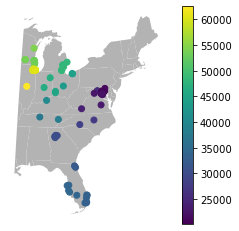

In [31]:
import geopandas
import pandas as pd
from shapely.geometry import Point, Polygon, box
b=box(-90,20,-55,50)
data = geopandas.read_file('locations.geojson')

code_list=[]
address_list=list(data['address'])
for i in range(len(address_list)):
    code=re.findall(r"[0-9]{5}$|[0-9]{5}-[0-9]{4}$",address_list[i])
    if len(code)>0:
        if len(code[0])==5:
            code_list.append(int(code[0]))
        else:
            code_list.append(int(code[0][:5]))
    else:
        code_list.append(0)
data['code']=code_list
data1=data[data['code']>=20000]
data2=data[data['code']<=70000]
data=geopandas.sjoin(data1,data2)
is_data=~data.intersection(b).is_empty
data=data[is_data]
region=geopandas.read_file("shapes/cb_2018_us_state_20m.shp")
background_region=region.intersection(b).to_crs(epsg=2022)
data_location=data.to_crs(epsg=2022)

ax=background_region.plot(color='0.7')
data_location.plot(ax=ax,figsize=(8,3),column='code_left',legend=True, cmap="viridis")
ax.set_axis_off()